#Visual Translation with Context using LLMs
This is a POC to test whether passing an LLM context about the context of text provided for translation improves the quality of the translation.

Take the following example where google translate struggles with the menu items on this vietnamese menu board.

![img](./example.png)



In [1]:
!pip install transformers pytesseract sentencepiece accelerate easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 14.1 MB/s eta 0:00:00


In [2]:
import torch
from transformers import pipeline
import cv2
import pytesseract
from matplotlib import pyplot as plt
import  numpy as np
from PIL import Image


# Classification Stage

This assigns a generic label from the iamgenet 1000 classifier which will be used later in creating a prompt to pass to the language model.

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 5dca96d (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.9984662532806396, 'label': 'menu'}


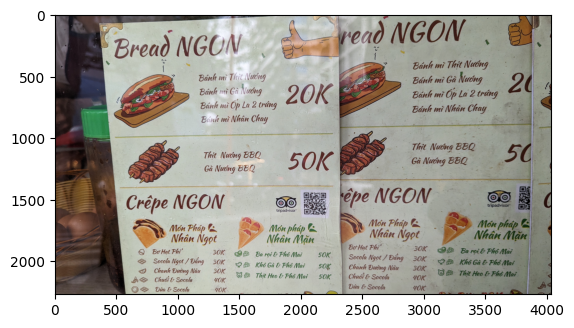

In [7]:
from transformers import ViTImageProcessor, ViTForImageClassification

def classify(input, model="default"):
  """
  Method to classify input image
  """
  if model == "default":
    # Default transformers classifier. Assigns labels from imagenet 1000.
    classifier = pipeline(task="image-classification", device="cpu")
    return classifier(input)[0]
  else:
    raise NotImplementedError(f"Model {model} not implemented.")


image = Image.open("./test_img.jpg")
print(classify(image))
plt.imshow(image)

# OCR

Module to capture text from image

## Bbox locating

In [8]:
import easyocr

class TextDetection:
  """
  Get bounding boxes containing text where the model exceeds a
  provided confidence thresold.

  # TODO: https://www.jaided.ai/easyocr/documentation/ fix according to
  """
  def __init__(self, model='easyocr', conf_thresh=0.5, language='en'):
    self.model = model
    self.conf_thresh = conf_thresh

    if self.model == 'easyocr':
      self.reader = easyocr.Reader([language]) #TODO: does this have its own thresh?
    else:
      raise NotImplementedError(f"Model {self.model} is not implemented.")

  def __call__(self, image):
    if self.model == 'easyocr':
      result = self.reader.readtext(image) #TODO: does this always produce rectangular boxes?

      sorted_result = sorted(result, reverse=True, key=lambda x: x[2])
      return [x for x in sorted_result if x[2] > self.conf_thresh]

def get_bboxes(image, model='easyocr', conf_thresh=0.5, language='en'):


  if model == 'easyocr':
    reader = easyocr.Reader([language]) #TODO: does this have its own thresh?
    result = reader.readtext(image) #TODO: does this always produce rectangular boxes?

    sorted_result = sorted(result, reverse=True, key=lambda x: x[2])
    return [x for x in sorted_result if x[2] > conf_thresh]
  else:
    raise NotImplementedError(f"Model {model} is not implemented.")

image = Image.open("./test_img.jpg")
bbox_detection = TextDetection(language='vi')
print("\n")
print(bbox_detection(image)[0])


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

([[1789, 1572], [1959, 1572], [1959, 1612], [1789, 1612]], 'tripadvisor', 0.9999502382459892)


In [9]:
# Get text from cropped bounding boxes

class OCR:
  """
  Class to extract text from detection areas
  """

  def __init__(self, model='easyocr', language='en'):
    self.model = model
    if self.model =='easyocr':
      self.reader = easyocr.Reader([language])
    else:
      raise NotImplementedError(f"Model {model} not implemented.")

  def __call__(self, input):
    if self.model == 'easyocr':
      result = self.reader.readtext(input)

      sorted_result = sorted(result, reverse=True, key=lambda x: x[2])
      if sorted_result:
        return sorted_result[0][1:]
      return []


def get_boxes_and_text(
    image,
    localisation_model='easyocr',
    character_model='easyocr',
    language='en',
    conf_thresh=0.5):
  result = []
  text_detection_model = TextDetection(model=localisation_model, language=language, conf_thresh=conf_thresh)
  text_recognition_model = OCR(model=character_model, language=language)

  bboxes = text_detection_model(image)
  for line in bboxes:
    boxes, _, confidence = line
    ltrb = [x for box in boxes[::2] for x in box]

    # run get_text
    cropped_img = np.array(image.crop(ltrb))
    res = text_recognition_model(cropped_img)
    if res:
      text, confidence = res
      result.append([boxes, text, confidence])

  return result

image = Image.open("./test_img.jpg")
result = get_boxes_and_text(image, language='vi')

## Translation model

In [41]:
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer


class TranslationModel:

  def __init__(self, model="m2m100_418M", src_lang="vi", tgt_lang="en"):

    self.src_lang=src_lang
    self.tgt_lang=tgt_lang

    self.model = M2M100ForConditionalGeneration.from_pretrained(
        f"facebook/{model}",
        torch_dtype="auto",
        device_map="auto")
    self.tokenizer = M2M100Tokenizer.from_pretrained(f"facebook/{model}")
    self.tokenizer.src_lang = src_lang

  def __call__(self, input):

    encoded_hi = self.tokenizer(input, return_tensors="pt")
    generated_tokens =self.model.generate(**encoded_hi, forced_bos_token_id=self.tokenizer.get_lang_id(self.tgt_lang))
    return self.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

trans_model = TranslationModel(src_lang="fr")
trans_model("Je suis trés grande")

['I am very big']

['by tripadvisor']
['Chocolate']
['Chocolate']
['Chocolate']
['The chicken']
['Rea']
['and the']
['Chay']
['BBQ']
['BBQ']
['Nude']
['None']
['and the']
['by tripadvisor']
['The chicken']
['[Pháp']
['The Hat Phi']
['Thit']
['Chanh']
['The bread man']
['Month']
['Monthly French']
['Thit Heo']
['Monthly French']
['by Ngot']
['Sweaters']
['The Salt']
['Eggs']
['by May.']
['BBQ']
['Chongqing and Phô Mai']
['4oK']
['Month']
['The bread man']
['Bread']
['Chocolate Ngot']
['Through']
['Chocolate & Chocolate']
['Fighting and Fighting May']
['4 OK']
['Bread Thit Nưóng']
['[Thinking']
['Chank']
['Thit Heo and Phô Mai']
['Chongqing and Phô Mai']
['by Phô Mai & Phô Mai']
['30K']
['by Chuôí']
['30K']
['Featured #at Phi']
['Chocolate & Chocolate']
['The bread is 2']
['Crêpe NGON']
['None']
['The bread is 2']
['rightly']
['Sweaters']
['I am so much.']
['5oK']
['Ooh']
['2 OK']
['by NGON']
['Bread Thit Nưóng']
['It is BBQ']
['3oK']


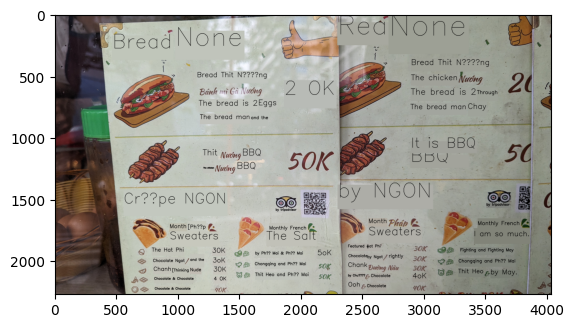

In [31]:
# Overlay text

from PIL import Image, ImageDraw, ImageFont
import numpy as np

def overlay_text(image, text, bbox_coords):

    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    thickness = 2

    # Convert image to np array
    # TODO: assert on image types
    image = np.array(image)

    # Extract the region within the bounding box
    x1, y1, x2, y2 = bbox_coords
    region = image[y1:y2, x1:x2]

    # Calculate the median color of the region
    median_color = tuple(np.median(region, axis=(0, 1)).astype(int))

    # Fill the bounding box on the overlay image with the median color
    image[y1:y2, x1:x2] = median_color

    # Calculate the width and height of the bounding box
    bbox_width = x2 - x1
    bbox_height = y2 - y1

    # Get size of text
    (baseline_text_width, baseline_text_height), _ = cv2.getTextSize(	text, fontFace, fontScale, thickness)

    # Calculate the size of the new text to fill the bounding box
    #text_width = len(text) * font_size // 2  # Approximate text width based on font size
    scale = min(bbox_height / baseline_text_height, bbox_width / baseline_text_width)
    new_font_size = int( 1 * scale)

    # Calculate the position for the new text
    text_x = x1 #+ (bbox_width - text_width * scale) // 2
    text_y = y1 + (bbox_height - new_font_size) // 2 + new_font_size

    # Draw the new text on the image
    cv2.putText(image, text, (int(text_x), int(text_y)), cv2.FONT_HERSHEY_SIMPLEX, scale, (0,0,0), 2, cv2.LINE_AA)

    # Convert the result to PIL Image format
    result = Image.fromarray(image)

    # Save the result to the specified output path
    return result



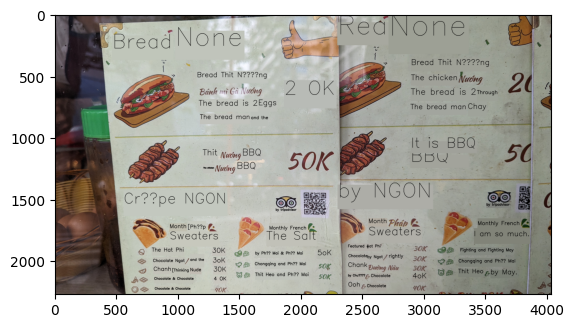

In [35]:
# open image
image = Image.open("./test_img.jpg")

# Find boxes and text within image
result = get_boxes_and_text(image, language='vi')

# translate text and overlay each on the image
for line in result:
  boxes, text, conf = line
  trans_txt = trans_model(text)[0]

  bbox_coords = [round(x) for box in boxes[::2] for x in box]
  image = overlay_text(image, trans_txt, bbox_coords)

plt.imshow(image)

# Query model

Testing some models that we can query with context and succesfully translate a sentence from vietnamese to english.

[model](https://huggingface.co/bigscience/bloomz-560m?text=Translate+to+English+from+Vietnamese%3A+B%C3%A1nh+m%C3%AC+thit+N%C6%B0%C3%B3ng.)


## Bloomz

Phrase "Translate to English from Vietnamese: Bánh mì thit Nưóng."

Expected output "Hot bread"

Output: "thit Nưóng" - Fail


Phrase: "Translate to English from French: Je t'aime."

Output: "Je t'aime"


Phrase: "Translate to English: Je t'aime."

Output: "I love you."


Phrase: "Translate from French to English: Je t'aime."

Output: "I love you."

Phrase: "Translate from Vietnamese to English: Je t'aime."

Output: "I love you."

Phrase: "Translate from Vietnamese to English: Bánh mì thit Nưóng."

Output: "</s>"

Phrase: "Translate to English: Bánh mì thit Nưóng."

Output: "</s>"

Phrase: "Translate to English: Bánh mì thit Nuóng."

Output: "</s>"

Phrase: "Translate from Vietnamese to English this text taken from a menu in vietnam: Bánh mì thit Nuóng."

Output: "this text taken from a menu in vietnam: Bánh mì thit Nuóng."

In [ ]:
# pip install -q transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

checkpoint = "bigscience/bloomz-560m"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint, torch_dtype="auto", device_map="auto")



In [ ]:
for line in result:
  box, text, score = line

  query = f"Translate this Vietnamese text taken from a menu to English. Text: {text}. Translation:"

  inputs = tokenizer.encode(query, return_tensors="pt").to("cuda")
  outputs = model.generate(inputs, max_new_tokens=50)
  print(tokenizer.decode(outputs[0]))
  break

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'result' is not defined

In [ ]:
class BloomzTranslationModel:
  """
  Class to query bloomz model for translation
  """

  def  __init__(self, model='bloomz-560m', source_lang="Vietnamese", target_lang="English"):
    assert model in ['bloomz-7b1', 'bloomz-3b', 'bloomz-1b7', 'bloomz-1b1', 'bloomz-560m']

    checkpoint = "bigscience/" + model

    self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    self.model = AutoModelForCausalLM.from_pretrained(checkpoint, torch_dtype="auto", device_map="auto")

    self.prompt = f"Translate this {source_lang} text taken from a menu to {target_lang}."

  def forward(self, text):

    query = self.prompt + f" Text: {text}. Translation:"
    inputs = tokenizer.encode(query, return_tensors="pt").to("cuda")
    outputs = model.generate(inputs, max_new_tokens=50)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)





In [ ]:
from transformers import AutoTokenizer, T5ForConditionalGeneration
import torch

device:str = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained("t5-large", model_max_length=100)
model = T5ForConditionalGeneration.from_pretrained("t5-large").to(device)

for prompt in ["Bánh mì Thit Nuróng", "My name is jeff."]:
    print("Input:", prompt)
    inputTokens = tokenizer("translate English to German: {}".format(prompt), return_tensors="pt").to(device)
    outputs = model.generate(inputTokens['input_ids'], attention_mask=inputTokens['attention_mask'], max_new_tokens=50)
    print("Output:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Input: Bánh mì Thit Nuróng
Output: Bánh m Thit Nuróng
Input: My name is jeff.
Output: Mein Name ist jeff.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("allenai/tk-instruct-small-def-pos")

model = AutoModelForSeq2SeqLM.from_pretrained("allenai/tk-instruct-large-def-pos")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = "cuda:0"

tokenizer = AutoTokenizer.from_pretrained("allenai/mtk-instruct-3b-def-pos")
model = AutoModelForSeq2SeqLM.from_pretrained("allenai/mtk-instruct-3b-def-pos").to(device)

input_ids = tokenizer.encode(
        "Definition: Translate from Vietnamese to English. Now complete the following example - Input: Bánh mì Thit Nưóng. Output:",
        return_tensors="pt").to(device)
output = model.generate(input_ids, max_length=10)
output = tokenizer.decode(output[0], skip_special_tokens=True)   # model should output 'Indian Rupee'
print(output)

#input_ids = tokenizer.encode(
#        "Definition: negate the following sentence. Input: John went to school. Output:",
#        return_tensors="pt")
#output = model.generate(input_ids, max_length=10)
#output = tokenizer.decode(output[0], skip_special_tokens=True)   # model should output 'John did not go to shool.'

#print(output)

Bánh mì Thit Nưóng


In [ ]:
input_ids = tokenizer.encode(
    "Definition: A text is given in Vietnamese. Translate it from the Vietnamese language to the English language. The translation must not omit or add information to the original sentence. Input: Bánh mì Thit Nưóng. Output:",
        return_tensors="pt").to(device)
output = model.generate(input_ids, max_length=50)
output = tokenizer.decode(output[0], skip_special_tokens=True)   # model should output 'Indian Rupee'
print(output)

Bánh mì Thit Nưóng


In [ ]:
# read gps data from image
from PIL import Image
from PIL.ExifTags import TAGS

def get_exif(filename):

    image = Image.open(filename)
    image.verify()
    return image._getexif()

def get_lat_lon(image_path):
    exif = get_exif(image_path)
    exif_data = {}
    if exif:

        for (tag, value) in exif.items():
            if tag in TAGS:
                exif_data[TAGS[tag]] = value

    # retrieve latitude and longitude from exif data
    lat = exif_data['GPSInfo'][2]
    lon = exif_data['GPSInfo'][4]

    # convert to degrees
    lat = lat[0] + lat[1]/60 + lat[2]/3600
    lon = lon[0] + lon[1]/60 + lon[2]/3600
    return lat, lon

lat, lon = get_lat_lon("./test_img.jpg")
print(float(lat), float(lon))



16.049333333333333 108.24576388888889


: 

: 